In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from uti.callback_04 import *
import math

In [3]:
#export
def one_batch(xb,yb,cb_handler):
    if not cb_handler.begin_batch(xb,yb): return
    preds = cb_handler.learn.model(xb)
    loss = cb_handler.learn.loss_func(preds,yb)
    if not cb_handler.after_loss(loss,preds): return
    if not cb_handler.begin_backward(): return
    loss.backward()
    if cb_handler.after_backward(): cb_handler.learn.opt.step()
    if cb_handler.after_step(): cb_handler.learn.opt.zero_grad()

def all_batches(dl, cb_handler):
    for xb,yb in dl:
        one_batch(xb,yb,cb_handler)
        if cb_handler.do_stop(): return 


def fit(epochs,learn,cb_handler):
    if not cb_handler.begin_fit(learn): return
    for epoch in range(epochs):
        if not cb_handler.begin_epoch(epoch): continue
        all_batches(learn.data.train_dl,cb_handler)
        
        if cb_handler.begin_validate():
            with torch.no_grad(): all_batches(learn.data.valid_dl,cb_handler)
        if cb_handler.do_stop() or not cb_handler.after_epoch(): break
    
    cb_handler.after_fit()

In [4]:
#export
class Accuracy(Callbacks):
    _order = 10
    def begin_epoch(self,epoch):
        self.total_loss, self.total_acc = 0,0
        return super().begin_epoch(epoch)
    
    def begin_validate(self):
        nv = len(self.learn.data.train_dl)
        print('Train: ', self.epoch, self.total_loss / nv, self.total_acc / nv)
        self.total_loss, self.total_acc = 0,0
        return True
    
    def accuracy(self, out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()
    
    def after_loss(self,loss,preds):
        self.total_loss += loss
        self.total_acc += self.accuracy(preds,self.yb)
        return True
    
    def after_epoch(self):
        total_batch = len(self.learn.data.valid_dl)
        print('Valid: ', self.epoch, self.total_loss / total_batch, self.total_acc / total_batch)
        return True

In [5]:
#export
class LRFind(Callbacks):
    def begin_fit(self,learn,start=1e-8,end=10.,beta=0.98):
        super().begin_fit(learn)
        self.start, self.end, self.beta = start, end, beta
        self.current_lr = start
        self.ratio = (end / start) ** (1 / (len(self.learn.data.train_dl)-1))
        self.lr = []
        self.losses = []
        self.best_loss = 0.
        self.avg_loss = 0.
        self.smooth_loss = 0.
        self.batch_num = 0
        return True
        
    def begin_batch(self,xb,yb):
        self.xb,self.yb = xb, yb
        self.batch_num += 1
        self.learn.opt.param_groups[0]['lr'] = self.current_lr
        return True
    
    def after_loss(self,loss,preds):
        self.loss = loss
        self.avg_loss = self.avg_loss * self.beta + self.loss.data * (1 - self.beta)
        self.smooth_loss = self.avg_loss / (1 - self.beta ** self.batch_num) #debias
        if self.batch_num > 1 and self.smooth_loss > 4 * self.best_loss:
            self.learn.stop = True
            return True
        if self.batch_num == 1 or self.best_loss > self.smooth_loss:
            self.best_loss = self.smooth_loss
            self.best_lr = self.current_lr
        self.losses.append(self.smooth_loss)
        self.lr.append(math.log10(self.current_lr))
        self.current_lr *= self.ratio
        return True
    
    def begin_validate(self):
        return False

In [6]:
lr_find = LRFind()

In [7]:
train_ds,valid_ds = get_dataset(*get_data())
data = Databunch(*get_dl(train_ds,valid_ds,bs=64),c=10)

loss_func = F.cross_entropy
learn = Learner(*get_model(data),loss_func,data)

/home/jupyter/.fastai/data/mnist.pkl.gz


In [8]:
fit(1,learn,cb_handler=CallbackHandler([lr_find]))

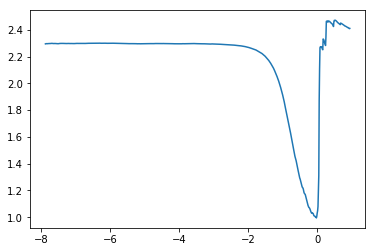

In [9]:
plt.plot(lr_find.lr[10:-5],lr_find.losses[10:-5])

In [10]:
lr_find.best_lr

0.9427397199780911

In [11]:
#export

from functools import partial 

def create_learner(model_func,loss_func,data):
    return Learner(*model_func(data),loss_func,data)

def get_model_func(get_model,lr=0.5):
    return partial(get_model,lr=lr)

In [27]:
learn = create_learner(get_model_func(get_model,lr=0.55),loss_func,data)

In [13]:
fit(5,learn,CallbackHandler([Accuracy()]))

Train:  0 tensor(0.3144, grad_fn=<DivBackward0>) tensor(0.9037)
Valid:  0 tensor(0.1842) tensor(0.9455)
Train:  1 tensor(0.1442, grad_fn=<DivBackward0>) tensor(0.9556)
Valid:  1 tensor(0.1536) tensor(0.9519)
Train:  2 tensor(0.1099, grad_fn=<DivBackward0>) tensor(0.9664)
Valid:  2 tensor(0.1229) tensor(0.9645)
Train:  3 tensor(0.0902, grad_fn=<DivBackward0>) tensor(0.9719)
Valid:  3 tensor(0.0960) tensor(0.9740)
Train:  4 tensor(0.0769, grad_fn=<DivBackward0>) tensor(0.9764)
Valid:  4 tensor(0.1401) tensor(0.9608)


In [14]:
learn.opt.param_groups[0]['lr']

0.55

In [15]:
#export
class Recorder(Callbacks):
    def begin_fit(self,learn):
        super().begin_fit(learn)
        self.losses, self.lrs = [], []
        return True
        
    def after_step(self): 
        ###Train Loss only###
        
        #Read callback_handlers, won't excute after_step() for valid
        #different from Jeremy's implementation where try...except...finally will always have finally excute
        #there is no point for validation mode to excute after_step
        
        self.lrs.append(self.learn.opt.param_groups[0]['lr'])
        self.losses.append(self.loss.detach().cpu())
        return True
    
    def plot_lr(self): plt.plot(self.lrs)
        
    def plot_loss(self): plt.plot(self.losses)

In [28]:
recorder = Recorder()

In [29]:
learn = create_learner(get_model_func(get_model,lr=0.55),loss_func,data)
fit(5,learn,CallbackHandler([Accuracy(),recorder]))

Train:  0 tensor(0.3199, grad_fn=<DivBackward0>) tensor(0.9008)
Valid:  0 tensor(0.1526) tensor(0.9564)
Train:  1 tensor(0.1451, grad_fn=<DivBackward0>) tensor(0.9560)
Valid:  1 tensor(0.1343) tensor(0.9606)
Train:  2 tensor(0.1119, grad_fn=<DivBackward0>) tensor(0.9663)
Valid:  2 tensor(0.1397) tensor(0.9586)
Train:  3 tensor(0.0932, grad_fn=<DivBackward0>) tensor(0.9714)
Valid:  3 tensor(0.1265) tensor(0.9646)
Train:  4 tensor(0.0789, grad_fn=<DivBackward0>) tensor(0.9754)
Valid:  4 tensor(0.1056) tensor(0.9703)


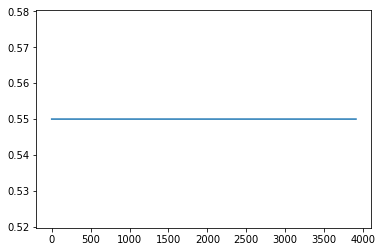

In [30]:
recorder.plot_lr()

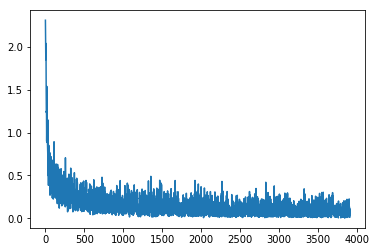

In [31]:
recorder.plot_loss()

# Schedule LR

In [20]:
#export

def annealer(f):
    def _inner(start,end): return partial(f,start,end)
    return _inner

In [21]:
#export

@annealer
def lin_sched(start,end,pos):
    return start + (end - start) * pos

In [22]:
f = lin_sched(1,2)

In [23]:
f(0.3)

1.3

In [24]:
#export

@annealer
def cos_sched(start,end,pos):
    return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2

@annealer
def no_sched(start,end,pos):
    return start

@annealer
def exp_sched(start,end,pos):
    return start * (end/start) ** pos

In [25]:
annealings = "NO LINEAR COS EXP".split()
annealings

['NO', 'LINEAR', 'COS', 'EXP']

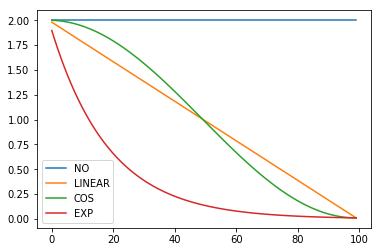

In [26]:
a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

torch.Tensor.ndim = property(lambda x: len(x.shape))

fns = [no_sched, lin_sched, cos_sched, exp_sched]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [37]:
pcts = torch.tensor([0]+[0.3,0.7])
pcts

tensor([0.0000, 0.3000, 0.7000])

In [42]:
torch.all(pcts >= 0.)

tensor(1, dtype=torch.uint8)

In [43]:
def combine_sched(pcts,scheds):
    assert sum(pcts) == 1
    pcts = torch.tensor([0] + pcts)
    assert torch.all(pcts >= 0.)
    pcts = torch.cumsum(pcts,0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [44]:
sched = combine_sched([0.3,0.7],[cos_sched(0.3,0.6),cos_sched(0.6,0.2)])

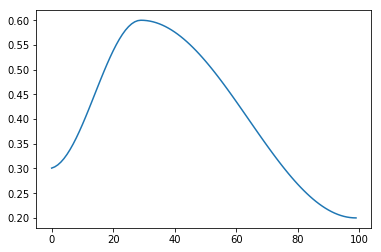

In [46]:
plt.plot(a, [sched(o) for o in p])

In [47]:
#export
class ParamScheduler(Callbacks):
    _order = 1
    def __init__(self, param_name, sched_func):
        self.param_name, self.sched_func = param_name, sched_func
        
    def set_param(self):
        for pname in self.learn.opt.param_groups:
            pname[param_name] = sched_func(self.iter / self.total_iters) #currently call back doesnt have iter,total_iters
        
    def begin_batch(self,xb,yb):
        super().begin_batch(xb,yb)
        self.set_param()
        return True